In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score, plot_roc_curve, RocCurveDisplay, roc_curve
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.base import BaseEstimator, RegressorMixin
import pickle

In [2]:
df = pd.read_csv("../data/FULL_Shot_Data.csv")
df.head()

,Unnamed: 0,id,minute,result,X,Y,xG,player,h_a,player_id,...,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,0,14642,83,BlockedShot,0.795,0.321,0.047510,Harry Kane,a,647,...,2014,RightFoot,4754,West Ham,Tottenham,0,1,2014-08-16 15:00:00,Andros Townsend,Pass
1,1,15400,81,OwnGoal,0.029,0.582,0.000000,Harry Kane,a,647,...,2014,OtherBodyPart,4724,Sunderland,Tottenham,2,2,2014-09-13 15:00:00,NaN,Foul
2,2,16333,68,SavedShot,0.906,0.469,0.435830,Harry Kane,h,647,...,2014,LeftFoot,4715,Tottenham,Newcastle United,1,2,2014-10-26 13:30:00,Danny Rose,Pass
3,3,16901,58,SavedShot,0.917,0.463,0.085788,Harry Kane,a,647,...,2014,Head,4657,Aston Villa,Tottenham,1,2,2014-11-02 16:00:00,Erik Lamela,Cross
4,4,16909,89,Goal,0.761,0.415,0.067692,Harry Kane,a,647,...,2014,RightFoot,4657,Aston Villa,Tottenham,1,2,2014-11-02 16:00:00,NaN,Standard


In [3]:
situations = df['situation'].unique()
print(situations)

['OpenPlay' 'SetPiece' 'FromCorner' 'DirectFreekick' 'Penalty']


In [20]:
class SituationRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, **kwargs):
        self.situations = situations
        self.models = {s: XGBClassifier(**kwargs) for s in self.situations}

    def fit(self, X, y=None):
        for s in self.situations:
            filtered = X[:,0] == s
            self.models[s].fit(X[filtered, 1:], y[filtered])
        return self

    def predict(self, X, y=None):
        df = pd.DataFrame(X)
        df2 = df.copy()
        df2['result'] = 0
        for s in situations:
            vals = df[df[0] == s]
            input_values = vals.iloc[:,1:].to_numpy()
            v = self.models[s].predict(input_values)
            df2.loc[df[0]==s, 'result'] = list(v)
        return (df2['result'].astype(int)).to_numpy()

    def predict_proba(self, X):
        df = pd.DataFrame(X)
        df2 = df.copy()
        df2['r1'] = 0.0
        df2['r2'] = 0.0
        for s in situations:
            vals = df[df[0] == s]
            input_values = vals.iloc[:,1:].to_numpy()
            v = self.models[s].predict_proba(input_values)
            df2.loc[df[0]==s, ['r1', 'r2']] = v
        return (df2[['r1', 'r2']].astype(float)).to_numpy()

    def save_to_file(self):
        for s in self.situations:
            pickle.dump(self.models[s], open(f"models/{s}.dat", "wb"))

In [21]:
attack_df = df[(df['result'] != 'OwnGoal')].copy() # exclude own goals

In [22]:
attack_df['outcome'] = (attack_df['result'] == 'Goal').astype(int)


In [23]:
input_data = attack_df[['X', 'Y', 'situation', 'shotType', 'outcome']].copy()
input_data_encoded = pd.concat([
        input_data[['situation', 'X', 'Y',]],
        pd.get_dummies(input_data['shotType'])
        ], axis=1)
output_data = input_data['outcome']
input_data_encoded.head()

,situation,X,Y,Head,LeftFoot,OtherBodyPart,RightFoot
0,OpenPlay,0.795,0.321,0,0,0,1
2,OpenPlay,0.906,0.469,0,1,0,0
3,FromCorner,0.917,0.463,1,0,0,0
4,DirectFreekick,0.761,0.415,0,0,0,1
5,OpenPlay,0.981,0.558,1,0,0,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(input_data_encoded.values, output_data.values, random_state=0, test_size=0.3)


In [25]:
reg = SituationRegressor(use_label_encoder=False)
reg.fit(X_train, y_train)

[22:22:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

SituationRegressor()

In [28]:
reg.save_to_file()

In [14]:
y_pred = reg.predict(X_test)

In [15]:
print("Test", accuracy_score(y_pred, y_test), "Train", accuracy_score(reg.predict(X_train), y_train), "ROC AUC Score", roc_auc_score(y_test, y_pred), "PR AUC Score", average_precision_score(y_test, y_pred))


Test 0.9042363520929545 Train 0.9079527071856154 ROC AUC Score 0.5868792472401498 PR AUC Score 0.21161953660921906


In [16]:
p_vals = reg.predict_proba(input_data_encoded.values)[:,1]
pred = list(p_vals)
attack_df['prediction'] = pred
attack_df[['xG', 'prediction', 'outcome']]


,xG,prediction,outcome
0,0.047510,0.021077,0
2,0.435830,0.265321,0
3,0.085788,0.073415,0
4,0.067692,0.266263,1
5,0.594700,0.316906,0
...,...,...,...
384458,0.014314,0.010803,0
384459,0.017178,0.022324,0
384460,0.020250,0.004963,0
384461,0.012068,0.012480,0


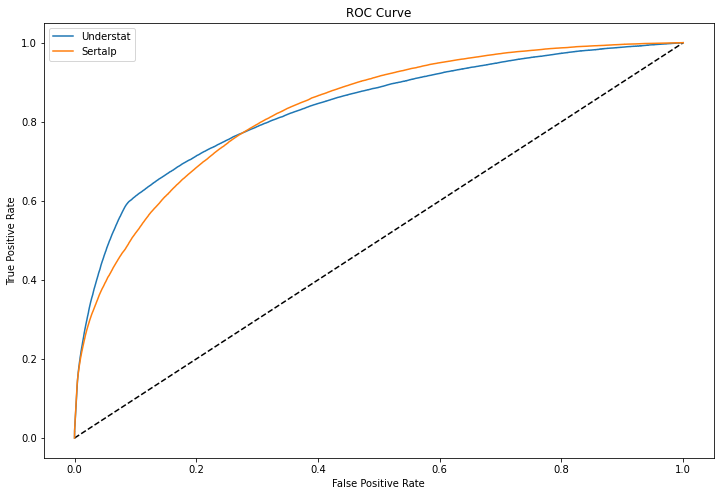

In [17]:
understat_fpr, understat_tpr, understat_thresholds = roc_curve(attack_df['outcome'], attack_df['xG'])
my_fpr, my_tpr, my_thresholds = roc_curve(attack_df['outcome'], attack_df['prediction'])
plt.figure(figsize=(12,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(understat_fpr, understat_tpr, label='Understat')
plt.plot(my_fpr, my_tpr, label='Sertalp')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [18]:
roc_auc_score(attack_df['outcome'], attack_df['prediction'])


0.8306569686676611

In [19]:
roc_auc_score(attack_df['outcome'], attack_df['xG'])


0.8316771452873846